# Introducción

<font color=green>
Este proyecto consta de preparar un prototipo de un modelo de machine learning para Zyfra. La empresa desarrolla soluciones de eficiencia para la industria pesada.
    
    
El modelo debe predecir la cantidad de oro extraído del mineral de oro. Dispones de los datos de extracción y purificación.
</font>

# Objetivo

<font color=green>
    
1. Analizar y preparar los datos;
    
2. Realizar el análisis de datos;

3. desarrollar un modelo y entrenarlo    
    
</font>

# Librerías y Datos

# Librerías

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

from numpy.random import RandomState

from sklearn.dummy import DummyRegressor

from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer

from sklearn.multioutput import MultiOutputRegressor

from sklearn.model_selection import cross_val_score, cross_validate, train_test_split

from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV

# Datos

In [2]:
try:
    data_train = pd.read_csv('gold_recovery_train.csv')
except:
    data_train = pd.read_csv('/datasets/gold_recovery_train.csv')
try:
    data_test = pd.read_csv('gold_recovery_test.csv')
except:
    data_test = pd.read_csv('/datasets/gold_recovery_test.csv')
try:
    data_full = pd.read_csv('gold_recovery_full.csv')
except:
    data_full = pd.read_csv('/datasets/gold_recovery_full.csv')

# Exploración de Datos

In [3]:
data_full.shape

(22716, 87)

In [4]:
data_train.shape

(16860, 87)

In [5]:
data_test.shape

(5856, 53)

<font color=green>
Observamos que el DataFrame full, tiene 87 columnas, al igual que DataFrame de entrenamiento. Pero el DataFrame de testeo tiene menos columnas.   
</font>

In [6]:
#Veamos qué columnas quedaron afuera del DF test

missing_columns = set(data_full.columns) - set(data_test.columns) #Obtenemos las columnas que faltan en el DataFrame de prueba

#Imprimimos las columnas que quedaron afuera
print('Columnas que quedaron fuera del DataFrame de prueba:')
print()
for columns in missing_columns:
    print(columns)


Columnas que quedaron fuera del DataFrame de prueba:

final.output.tail_pb
primary_cleaner.output.tail_au
rougher.output.tail_ag
secondary_cleaner.output.tail_au
final.output.concentrate_pb
primary_cleaner.output.tail_sol
rougher.calculation.floatbank10_sulfate_to_au_feed
final.output.concentrate_ag
secondary_cleaner.output.tail_ag
secondary_cleaner.output.tail_pb
primary_cleaner.output.concentrate_pb
primary_cleaner.output.tail_ag
primary_cleaner.output.concentrate_ag
rougher.output.tail_pb
primary_cleaner.output.concentrate_sol
rougher.output.concentrate_ag
primary_cleaner.output.concentrate_au
rougher.calculation.au_pb_ratio
rougher.output.concentrate_sol
final.output.concentrate_au
final.output.recovery
rougher.calculation.sulfate_to_au_concentrate
rougher.calculation.floatbank11_sulfate_to_au_feed
secondary_cleaner.output.tail_sol
final.output.concentrate_sol
primary_cleaner.output.tail_pb
final.output.tail_sol
rougher.output.tail_sol
rougher.output.tail_au
rougher.output.recovery

<font color=green>
    
Podemos observar que las columnas faltantes en el DataFrame de prueba, son las columnas de `output` que nuestros modelos deben predecir. 

Para testear nuestros modelos podremos econtrar estos objetivos en el DataFrame `data_full`. 

Primero debemos comprobar que el cálculo de la recuperación de la característica `rouger.output.recovery`en nuestro DataFrame de entrenamiento se ha hecho correctamente. Comprobaremos el resultado de los cálculos y la característica según la métrica EAM.
    
</font>

### rouger.output.recovery


In [7]:
# Numerador para nuestros cálculos
num = data_train['rougher.output.concentrate_au']*(data_train['rougher.input.feed_au'] - data_train['rougher.output.tail_au'])

#Denominador para nuestros cálculos
dem = data_train['rougher.input.feed_au']*(data_train['rougher.output.concentrate_au'] - data_train['rougher.output.tail_au'])

#Calculemos el EAM entre nuestro cálculo y los resultados
print('Valor del EAM entre nuestro cálculo y los resultados:', (data_train['rougher.output.recovery'] - num/dem*100).abs().mean())

Valor del EAM entre nuestro cálculo y los resultados: 9.303415616264301e-15


<font color=green>
    
Teniendo un EAM bastante bajo, podremos estar seguros que los datos y los resultado se encuentran correcto. La pequeña diferencia con 0, podrían deberse a algunos datos faltantes o vacíos.    

Como se mencionó al momento de recibir los datos; algunos parámetros no están disponibles porque fueron medidos o calculados mucho más tarde. Por eso, algunas de las características que están presentes en el conjunto de entrenamiento pueden estar ausentes en el conjunto de prueba. El conjunto de prueba tampoco contiene objetivos.
    
</font>

## Preprocesamiento de datos

<font color=green>
    
Si bien, como observamos anteriormente, el DataFrame completo cuenta con una totalidad de 87 columnas. Veremos la cantidad de datos que tiene cada una de ellas. 

Respecto al DataFrame de entrenamiento y prueba, los llenaremos posteriormente

</font>

In [8]:
data_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                22716 non-null  object 
 1   final.output.concentrate_ag                         22627 non-null  float64
 2   final.output.concentrate_pb                         22629 non-null  float64
 3   final.output.concentrate_sol                        22331 non-null  float64
 4   final.output.concentrate_au                         22630 non-null  float64
 5   final.output.recovery                               20753 non-null  float64
 6   final.output.tail_ag                                22633 non-null  float64
 7   final.output.tail_pb                                22516 non-null  float64
 8   final.output.tail_sol                               22445 non-null  float64


<font color=green>
    
Podemos observar que existen solamente 2 columnas con los datos completos; las cuales son `date` y `primary_cleaner.input.feed_size`. Veamos más en detalle la distribución de datos de esta última columna.
</font>

In [9]:
all_columns_full = len(data_full)
percentage_missing = (data_full.isnull().sum() / all_columns_full)*100
print(percentage_missing)

date                                          0.000000
final.output.concentrate_ag                   0.391794
final.output.concentrate_pb                   0.382990
final.output.concentrate_sol                  1.694841
final.output.concentrate_au                   0.378588
                                                ...   
secondary_cleaner.state.floatbank5_a_level    0.444621
secondary_cleaner.state.floatbank5_b_air      0.444621
secondary_cleaner.state.floatbank5_b_level    0.440218
secondary_cleaner.state.floatbank6_a_air      0.523860
secondary_cleaner.state.floatbank6_a_level    0.444621
Length: 87, dtype: float64


In [10]:
all_columns_train = len(data_train)
percentage_missing_train = (data_train.isnull().sum() / all_columns_full)*100
print(percentage_missing_train)

date                                          0.000000
final.output.concentrate_ag                   0.316957
final.output.concentrate_pb                   0.316957
final.output.concentrate_sol                  1.628808
final.output.concentrate_au                   0.312555
                                                ...   
secondary_cleaner.state.floatbank5_a_level    0.374186
secondary_cleaner.state.floatbank5_b_air      0.374186
secondary_cleaner.state.floatbank5_b_level    0.369783
secondary_cleaner.state.floatbank6_a_air      0.453425
secondary_cleaner.state.floatbank6_a_level    0.374186
Length: 87, dtype: float64


In [11]:
all_columns_test = len(data_test)
percentage_missing_test = (data_test.isnull().sum() / all_columns_full)*100
print(percentage_missing_test)

date                                          0.000000
primary_cleaner.input.sulfate                 1.329459
primary_cleaner.input.depressant              1.250220
primary_cleaner.input.feed_size               0.000000
primary_cleaner.input.xanthate                0.730762
primary_cleaner.state.floatbank8_a_air        0.070435
primary_cleaner.state.floatbank8_a_level      0.070435
primary_cleaner.state.floatbank8_b_air        0.070435
primary_cleaner.state.floatbank8_b_level      0.070435
primary_cleaner.state.floatbank8_c_air        0.070435
primary_cleaner.state.floatbank8_c_level      0.070435
primary_cleaner.state.floatbank8_d_air        0.070435
primary_cleaner.state.floatbank8_d_level      0.070435
rougher.input.feed_ag                         0.070435
rougher.input.feed_pb                         0.070435
rougher.input.feed_rate                       0.176087
rougher.input.feed_size                       0.096848
rougher.input.feed_sol                        0.294946
rougher.in

In [12]:
data_full['primary_cleaner.input.feed_size'].describe()

count    22716.000000
mean         7.288872
std          0.617357
min          1.080000
25%          6.920000
50%          7.280000
75%          7.680000
max         15.500000
Name: primary_cleaner.input.feed_size, dtype: float64

<font color=green>
Al ver el detalle, vemos que los valores de la media y mediana son casi iguales para esta columna. Y parecen estar bien equilibrados.    
    
</font>

### Columnas de `output`

<font color=green>
    
Para asegurarnos, veremos las columnas de `output` con unos boxplot, ya que serán de gran importancia para crear nuestros modelos.    
</font>

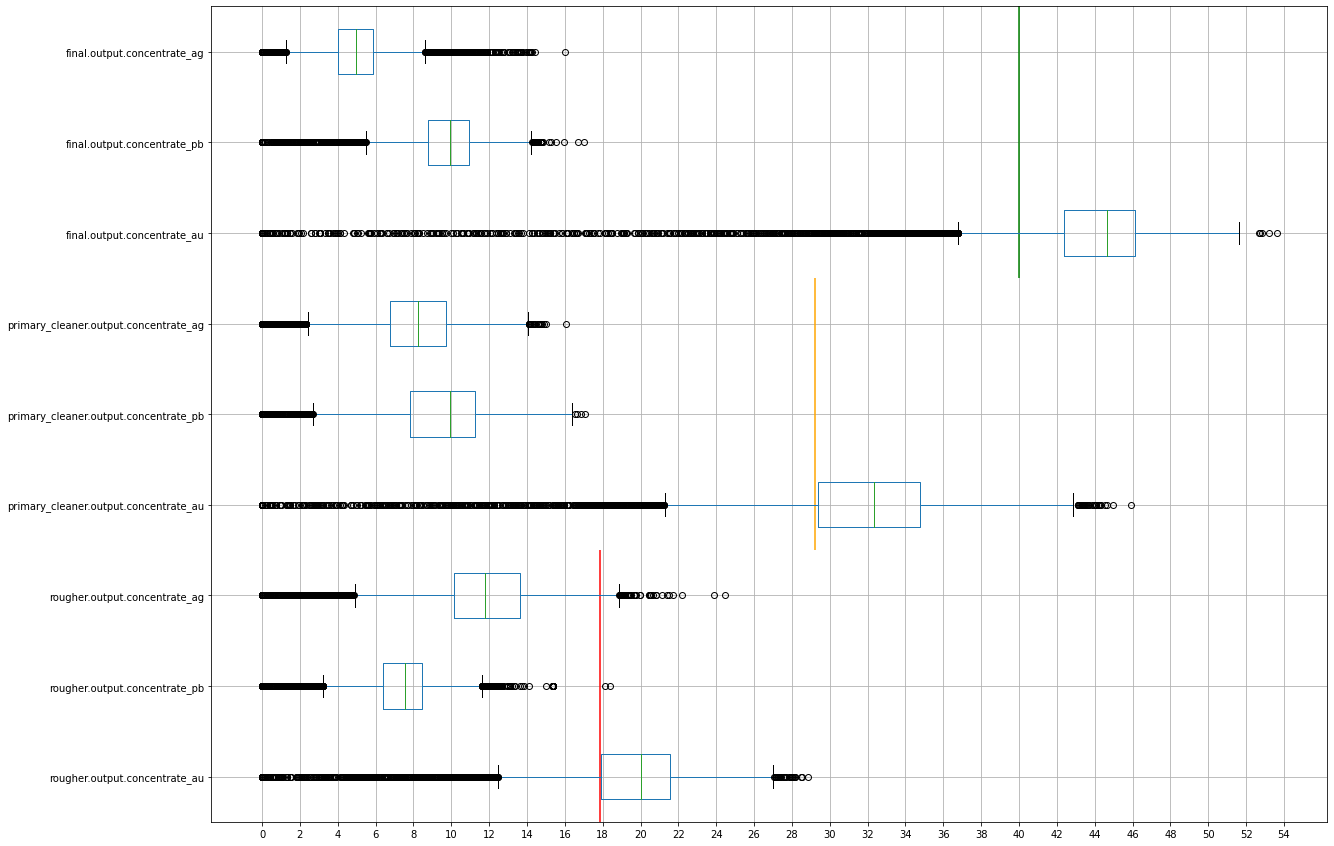

In [13]:
data_full.boxplot(['rougher.output.concentrate_au'
                  , 'rougher.output.concentrate_pb'
                  , 'rougher.output.concentrate_ag'
                  , 'primary_cleaner.output.concentrate_au'
                  , 'primary_cleaner.output.concentrate_pb'
                  , 'primary_cleaner.output.concentrate_ag'
                  , 'final.output.concentrate_au'
                  , 'final.output.concentrate_pb'
                  , 'final.output.concentrate_ag'], figsize=(20,15), vert=False)

plt.xticks(np.arange(0, 55, 2.0))

#Promedio de rougher del oro en color rojo
plt.vlines(data_full['rougher.output.concentrate_au'].mean(), ymin=0.5, ymax=3.5, colors='red')

#Promedio de la purificación primario del oro en color naranja
plt.vlines(data_full['primary_cleaner.output.concentrate_au'].mean(), ymin=3.5, ymax=6.5, colors='orange')

#Promedio de la purificación secundaria del oro en color verde
plt.vlines(data_full['final.output.concentrate_au'].mean(), ymin=6.5, ymax=9.5, colors='green')

plt.show()


<font color=green>
    
Observamos una clara tendencia de valores bajo la norma y promedios y atípicos. Podríamos eliminarlos, pero serían muchos datos que se perdería, esto no siendo bueno. Podremos aprovechar que los datos se encuentran ordenado por las fechas y utilizar el método `ffill` para que cada dato se llene según el dato anterior en el tiempo.     
</font>

In [14]:
#Llenemos los DataFrame de entrenamiento y prueba
data_train = data_train.fillna(method='ffill')
data_test = data_test.fillna(method='ffill')

#Aprovechamos de llenar el DataFrame completo también
data_full = data_full.fillna(method='ffill')

In [15]:
#Verifiquemos si quedaron bien
#data_train.isna().sum()

In [16]:
#data_test.isna().sum()

In [17]:
#data_full.isna().sum()

<font color=green>
    
Logramos llenar todos los datos de todas las columnas.     
</font>

# Análisis de datos

<font color=green>
    
En esta sección veremos 3 partes:

1. Observaremos cómo cambia la concentración de metales (Au, Ag, Pb) en función de la etapa de purificación

2. Compararemos las distribuciones del tamaño de las partículas de la alimentación en el conjunto de entrenamiento y en el conjunto de prueba. Si las distribuciones varían significativamente, la evaluación del modelo no será correcta

3. Consideraremos las concentraciones totales de todas las sustancias en las diferentes etapas: materia prima, concentrado rougher y concentrado final.
    ¿Observas algún valor anormal en la distribución total? Si es así, ¿merece la pena eliminar esos valores de ambas muestras?.
</font>

## 1. Concentración de metales en la etapa de purificación

<font color=green>
    
Comenzaremos viendo las concentraciones de cada metal, encontrando los datos ordenados según la etapa, tipo de parámetro y nombre del parámetro. por ejemplo: `[stage].[parameter_type].[parameter_name]`, o sea:
- stage o etapa: `primary_cleaner`, `secondary_cleaner` o `final`
- parameter_type o tipo de parámetro: `output`
- parameter_name o nombre de parámetro: `concentrate_au`, `conentrate_ag`, `tail_au`, `tail_ag` o `concentrate_pb`, `tail_pb`

Según los datos dados, el concentrado rougher se pasa por dos etapas de limpieza. Después de eso, obtenemos el concentrado final y las colas rougher. Lo que nos generará 4 medidas por cada metal. El concentrado y la cola de cada proceso de limpieza. Por tema de que las colas rougher de cada proceso son mucho menores, tomaremos en consideración solamente los concentrados de cada metal.

</font>

### Au; Oro
<font color=green>
    
Veamos la concentración de oro.    
</font>

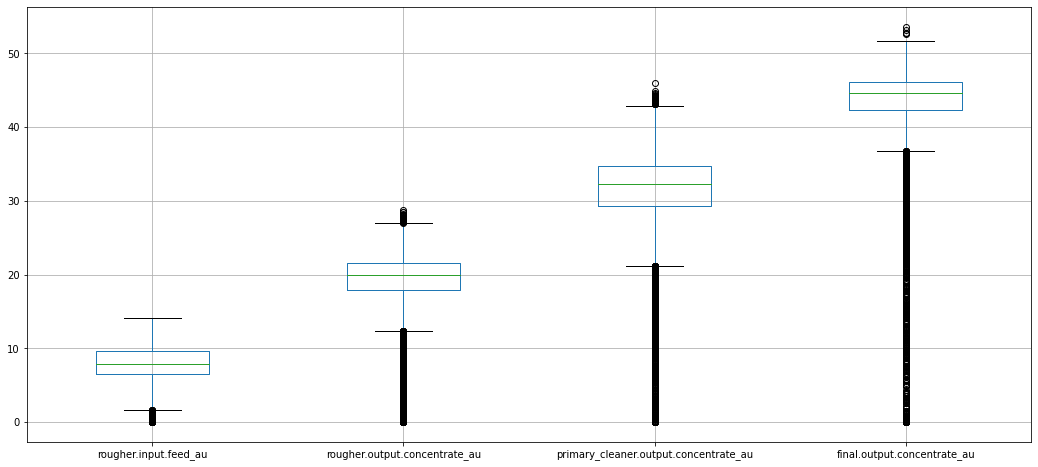

In [18]:
data_full.boxplot(['rougher.input.feed_au', 'rougher.output.concentrate_au', 'primary_cleaner.output.concentrate_au', 'final.output.concentrate_au'], figsize=(18,8))
plt.show()

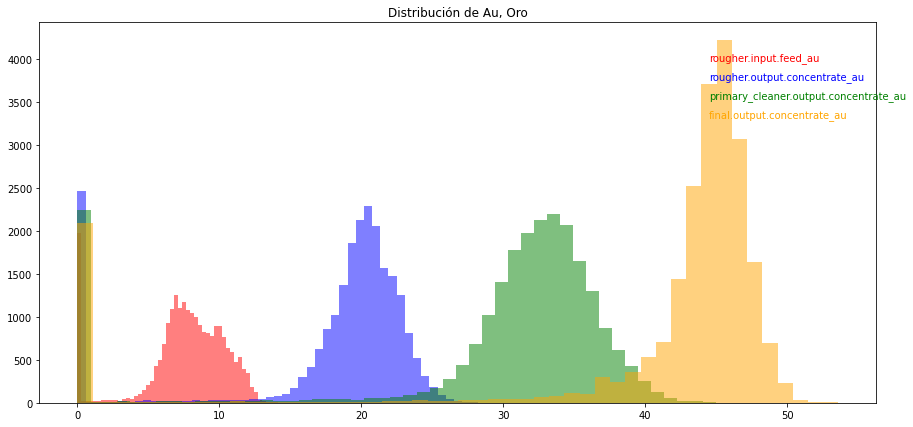

In [19]:
plt.figure(figsize=(15, 7))
plt.hist(data_full['rougher.input.feed_au'], alpha=0.5, label='rougher.input.feed_au', bins = 50, color='red')
plt.hist(data_full['rougher.output.concentrate_au'], alpha=0.5, label='rougher.output.concentrate_au', bins = 50, color='blue')
plt.hist(data_full['primary_cleaner.output.concentrate_au'], alpha=0.5, label='primary_cleaner.output.concentrate_au', bins = 50, color='green')
plt.hist(data_full['final.output.concentrate_au'], alpha=0.5, label='final.output.concentrate_au', bins = 50, color='orange')
plt.title('Distribución de Au, Oro')
plt.text(0.8, 0.9, 'rougher.input.feed_au', color='red', transform=plt.gca().transAxes)
plt.text(0.8, 0.85, 'rougher.output.concentrate_au', color='blue', transform=plt.gca().transAxes)
plt.text(0.8, 0.8, 'primary_cleaner.output.concentrate_au', color='green', transform=plt.gca().transAxes)
plt.text(0.8, 0.75, 'final.output.concentrate_au', color='orange', transform=plt.gca().transAxes)
plt.show()

In [20]:
# data_full.hist(['rougher.input.feed_au', 'rougher.output.concentrate_au', 'primary_cleaner.output.concentrate_au', 'final.output.concentrate_au'], figsize=(18,8), alpha = 0.5)
# plt.show()

<font color=green>
Según lo observado, vemos que al paso de cada etapa, la cantidad de oro va aumentando. Lo que tiene sentido, ya que el objetivo de este proceso es justamente esto, obtención de oro.  
</font>



### Ag; Plata
<font color=green>
Sigamos viendo el proceso, pero con la plata    
</font>

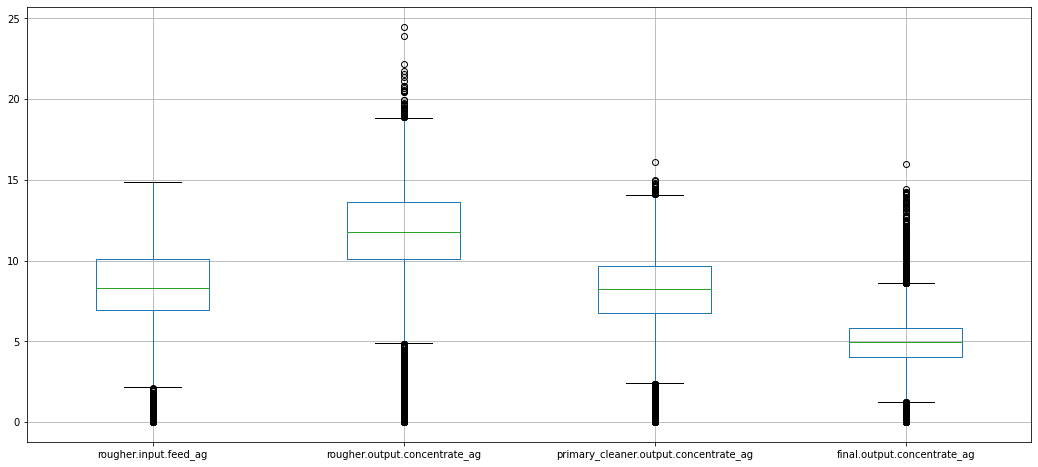

In [21]:
data_full.boxplot(['rougher.input.feed_ag', 'rougher.output.concentrate_ag', 'primary_cleaner.output.concentrate_ag', 'final.output.concentrate_ag'], figsize=(18,8))
plt.show()

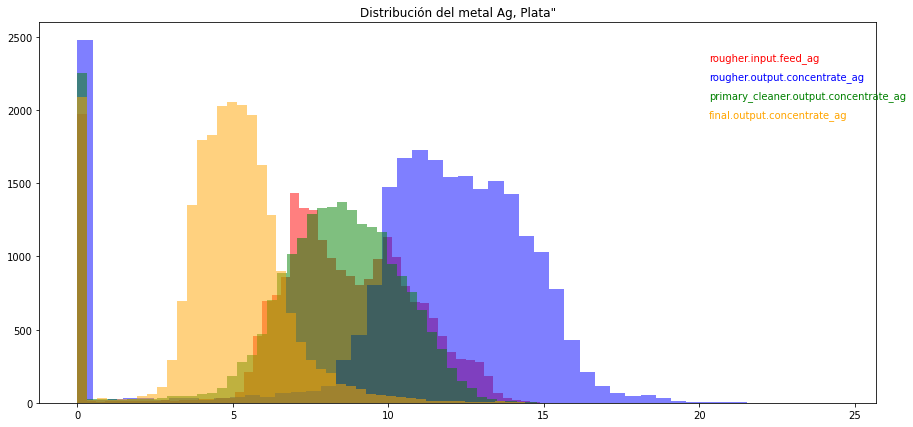

In [22]:
plt.figure(figsize=(15, 7))
plt.hist(data_full['rougher.input.feed_ag'], alpha=0.5, label='rougher.input.feed_ag', bins = 50, color='red')
plt.hist(data_full['rougher.output.concentrate_ag'], alpha=0.5, label='rougher.output.concentrate_ag', bins = 50, color='blue')
plt.hist(data_full['primary_cleaner.output.concentrate_ag'], alpha=0.5, label='primary_cleaner.output.concentrate_ag', bins = 50, color ='green')
plt.hist(data_full['final.output.concentrate_ag'], alpha=0.5, label='final.output.concentrate_ag', bins = 50, color='orange')
plt.title('Distribución del metal Ag, Plata"')
plt.text(0.8, 0.9, 'rougher.input.feed_ag', color='red', transform=plt.gca().transAxes)
plt.text(0.8, 0.85, 'rougher.output.concentrate_ag', color='blue', transform=plt.gca().transAxes)
plt.text(0.8, 0.8, 'primary_cleaner.output.concentrate_ag', color='green', transform=plt.gca().transAxes)
plt.text(0.8, 0.75, 'final.output.concentrate_ag', color='orange', transform=plt.gca().transAxes)
plt.show()

In [23]:
# data_full.hist(['rougher.input.feed_ag', 'rougher.output.concentrate_ag', 'primary_cleaner.output.concentrate_ag', 'final.output.concentrate_ag'], figsize=(18,8))
# plt.show()

<font color=green>
    
Observamos un comportamiento diferente al del Oro. Si bien en el `rougher.output.concentrate_ag` la cantidad de plata extraída es alta, es el punto más alto dentro del proceso, disminuyendo después.   
</font>

### Pb; Plomo
<font color=green>
Sigamos viendo el proceso, pero con el plomo    
</font>

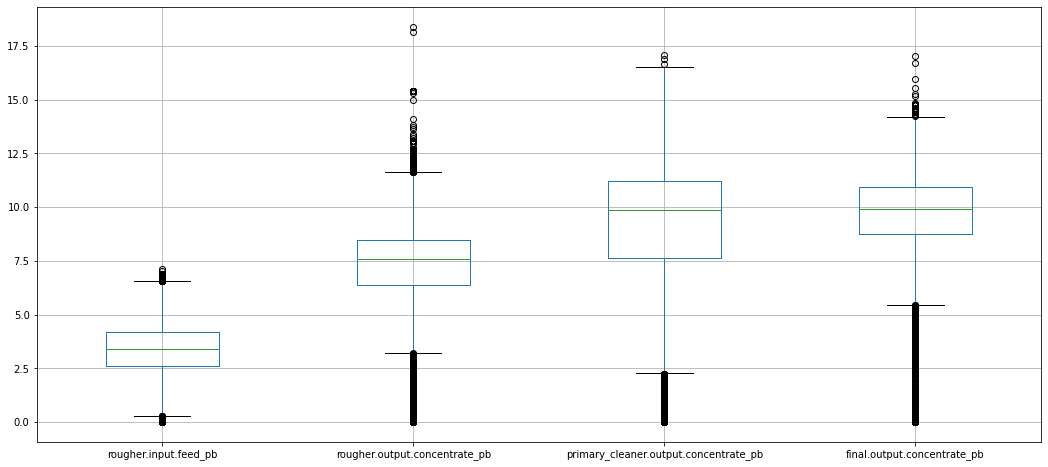

In [24]:
data_full.boxplot(['rougher.input.feed_pb', 'rougher.output.concentrate_pb', 'primary_cleaner.output.concentrate_pb', 'final.output.concentrate_pb'], figsize=(18,8))
plt.show()

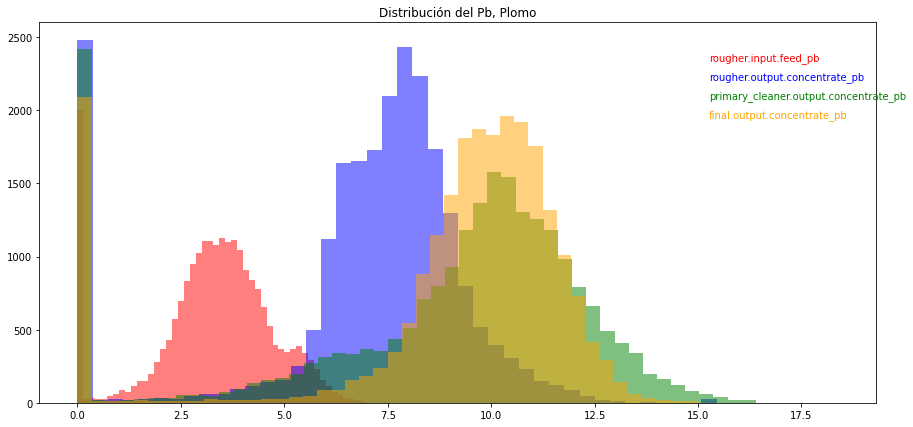

In [25]:
plt.figure(figsize=(15, 7))
plt.hist(data_full['rougher.input.feed_pb'], alpha=0.5, label='rougher.input.feed_pb', bins = 50, color='red')
plt.hist(data_full['rougher.output.concentrate_pb'], alpha=0.5, label='rougher.output.concentrate_pb', bins = 50, color='blue')
plt.hist(data_full['primary_cleaner.output.concentrate_pb'], alpha=0.5, label='primary_cleaner.output.concentrate_pb', bins = 50, color='green')
plt.hist(data_full['final.output.concentrate_pb'], alpha=0.5, label='final.output.concentrate_pb', bins = 50, color='orange')
plt.title('Distribución del Pb, Plomo')
plt.text(0.8, 0.9, 'rougher.input.feed_pb', color='red', transform=plt.gca().transAxes)
plt.text(0.8, 0.85, 'rougher.output.concentrate_pb', color='blue', transform=plt.gca().transAxes)
plt.text(0.8, 0.8, 'primary_cleaner.output.concentrate_pb', color='green', transform=plt.gca().transAxes)
plt.text(0.8, 0.75, 'final.output.concentrate_pb', color='orange', transform=plt.gca().transAxes)
plt.show()

In [26]:
# data_full.hist(['rougher.input.feed_pb', 'rougher.output.concentrate_pb', 'primary_cleaner.output.concentrate_pb', 'final.output.concentrate_pb'], figsize=(18,8))
# plt.show()

<font color=green>
    
Con el plomo observamos algo parecido al Oro. Al pasar las etapas, va aumentando su extracción, menos hacia el final, que llega a mantenerse en la cantidad.   
</font>

## 2. Distribuciones del tamaño de las partículas de la alimentación

<font color=green>
    
Como descrito anteriormente, en este paso compararemos las distribuciones del tamaño de las partículas (`feed_size`) de la alimentación en el conjunto de entrenamiento y en el conjunto de prueba.  
</font>

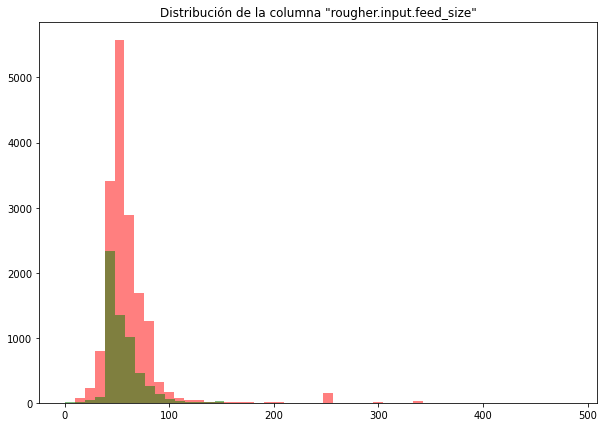

In [27]:
plt.figure(figsize=(10, 7))
plt.hist(data_train['rougher.input.feed_size'], alpha=0.5, label='data_train', bins = 50, color='red')
plt.hist(data_test['rougher.input.feed_size'], alpha=0.5, label='data_test', bins = 50, color='green')
plt.title('Distribución de la columna "rougher.input.feed_size"')
plt.show()

### Conjunto de entrenamiento

In [28]:
# data_train.boxplot(['rougher.input.feed_size', 'primary_cleaner.input.feed_size'], figsize=(18,8))
# plt.show()

In [29]:
#analizemos el 'rougher.input.feed_size' del conjunto de entrenamiento
data_train['rougher.input.feed_size'].describe()

count    16860.000000
mean        60.188595
std         30.522242
min          9.659576
25%         47.548897
50%         54.066003
75%         65.397249
max        484.967466
Name: rougher.input.feed_size, dtype: float64

In [30]:
#analizemos el 'primary_cleaner.input.feed_size' del conjunto de entrenamiento
# data_train['primary_cleaner.input.feed_size'].describe()

### Conjunto de prueba

In [31]:
# #veamos un boxplot
# data_test.boxplot(['rougher.input.feed_size', 'primary_cleaner.input.feed_size'], figsize=(18,8))
# plt.show()

In [32]:
#analizemos el 'rougher.input.feed_size' del conjunto de prueba
data_test['rougher.input.feed_size'].describe()

count    5856.000000
mean       55.898866
std        22.707969
min         0.046369
25%        43.852884
50%        49.964796
75%        61.628003
max       477.445473
Name: rougher.input.feed_size, dtype: float64

In [33]:
#analizemos el 'primary_cleaner.input.feed_size' del conjunto de prueba
# data_test['primary_cleaner.input.feed_size'].describe()

<!-- <font color=green>
    
Tanto en el conjunto de entrenamiento y prueba, podemos observar que el tamaño de partículas disminuye después del primer ciclo de purificación. Que hace lógica, ya que el rougher input contiene muchos otros elementos extras que son extraídos y eliminados en este paso.

En ambos conjuntos, la media como mediana son relativamente parecidos en la columna `rougher.input.feed_size`y en la columna `primary_cleaner.input.feed_size`.
</font> -->


<font color=green>
       
Comparando la columna `rougher.input.feed_size`, podemos observar la distribución de la variable, tanto en el conjunto de entrenamiento como en el de prueba, son muy parecidos. Esto es bueno porque indica que la distribución del atributo es consistente entre los conjuntos.
   
Ambos conjuntos de datos muestran una distribución sesgada hacia la izquierda con un pico alrededor de las 50 unidades. Y a su vez, asimétrico.    

</font>

### 3. Concentraciones totales de todas las sustancias en las diferentes etapas

<font color=green>
    
En este punto, necesitamos responder: ¿Observamos algún valor anormal en la distribución total? Si es así, ¿merece la pena eliminar esos valores de ambas muestras? 

Para poder responder esto, nos fijaremos en las concentraciones de cada metal en cada etapa. Las mediremos con una gráfica de cajas, con bigotes. Eliminaremos los valores atípicos según la concentración de otro, por ser el metal más importante y el objetivo de los procesos de filtración.
</font>




<!-- <font color=green>
 ~~Crearemos funciones que nos permitirán eliminar los valores atípicos~~    
</font> -->

In [34]:
# #Función que permite encontrar bigote superior
# def up_iqr_finder(data, column):
#     return data[column].quantile(0.75) + (data[column].quantile(0.75) - data[column].quantile(0.25))*1.5

# #Función que permite encontrar bigote inferior
# def down_iqr_finder(data, column):
#     return data[column].quantile(0.25) - (data[column].quantile(0.75) - data[column].quantile(0.25))*1.5

# #Función que permite filtrar el dataset con los valores típicos encontrados dentro de los límites de los bigotes
# def iqr_limit(data, limit_up, limit_down, column):
#     data_set = data[(data[column]<=limit_up) & (data[column]>=limit_down)]
#     return data_set

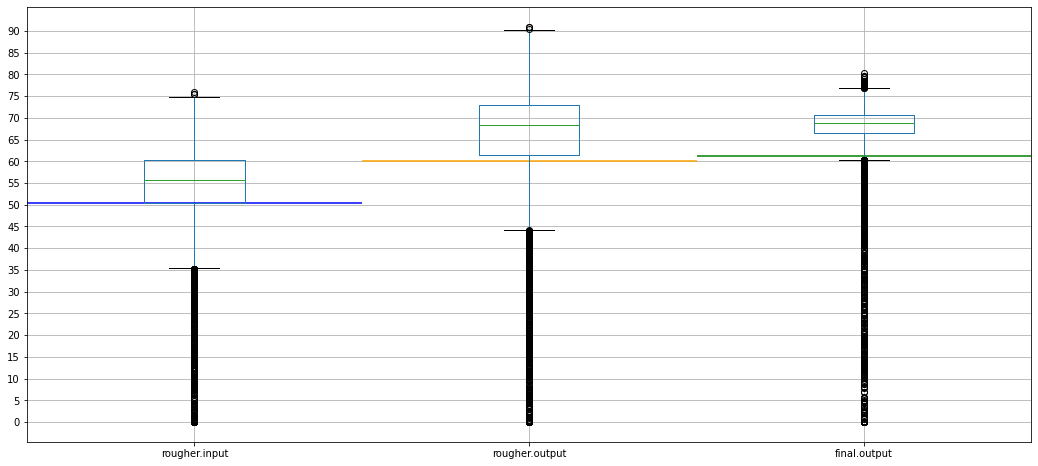

In [35]:
#Juntamos las entradas del rougher
data_train['rougher.input'] = data_train['rougher.input.feed_ag']+data_train['rougher.input.feed_au']+data_train['rougher.input.feed_pb']+data_train['rougher.input.feed_sol']

#Juntamos las salidas del rougher
data_train['rougher.output'] = data_train['rougher.output.concentrate_au']+data_train['rougher.output.concentrate_ag']+data_train['rougher.output.concentrate_pb']+data_train['rougher.output.concentrate_sol']

#Juntamos las salidas del proceso final
data_train['final.output'] = data_train['final.output.concentrate_au']+data_train['final.output.concentrate_ag']+data_train['final.output.concentrate_pb']+data_train['final.output.concentrate_sol']

#Creamos un gráfico
data_train.boxplot(['rougher.input', 'rougher.output','final.output'], figsize=(18,8))
plt.yticks(np.arange(0, 91, 5))
#Promedio de input del proceso rougher, en azul
plt.hlines(data_train['rougher.input'].mean(),xmin=0.5,xmax=1.5,colors='blue')
#Promedio de output del proceso rougher, en naranja
plt.hlines(data_train['rougher.output'].mean(),xmin=1.5,xmax=2.5,colors='orange')
#Promedio de output final del proceso, en verde
plt.hlines(data_train['final.output'].mean(),xmin=2.5,xmax=3.5,colors='green')

plt.show()

<font color=green>

Veamos los datos, pero con un histograma, manteniendo los mismos colores
</font>

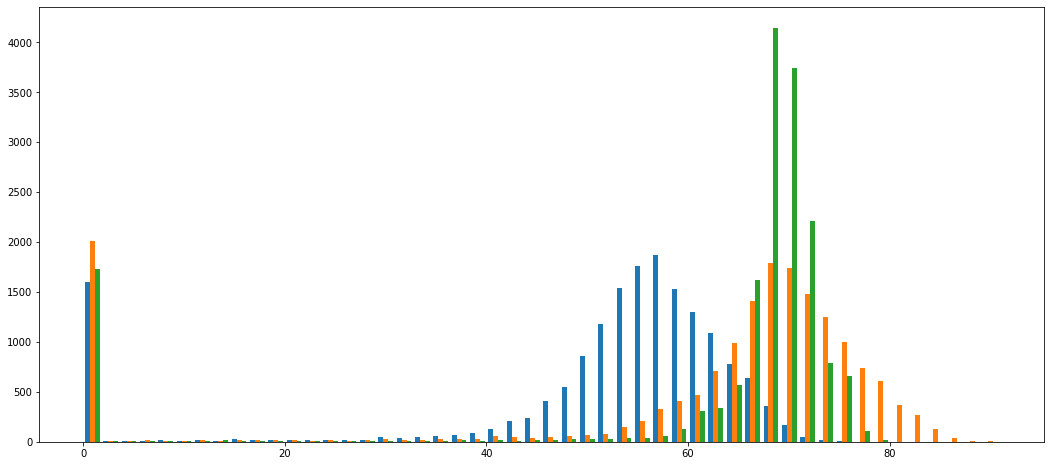

In [36]:
plt.figure(figsize=(18,8))
plt.hist([data_train['rougher.input'], data_train['rougher.output'], data_train['final.output']], bins=50)

plt.show()

<font color=green>

Veamos cada concentración con su Histograma individual
</font>

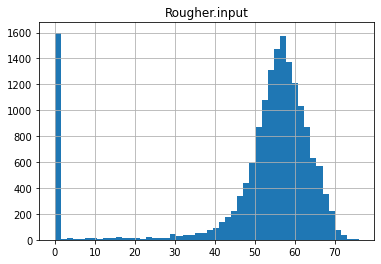

In [37]:
data_train['rougher.input'].hist(bins=50)
plt.title('Rougher.input')
plt.show()

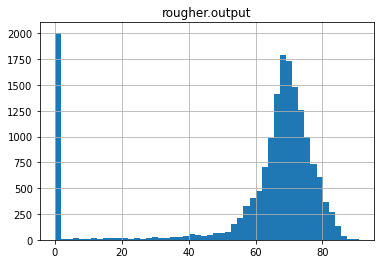

In [38]:
data_train['rougher.output'].hist(bins=50)
plt.title('rougher.output')
plt.show()

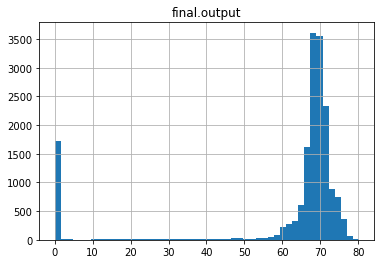

In [39]:
data_train['final.output'].hist(bins=50)
plt.title('final.output')
plt.show()

<font color=green>

Observamos que en cada una de las 3 concentraciones hay gran valor en 0, los cuales elimnaremos y mostraremos como quedan los histogramas sin estos valores
</font>

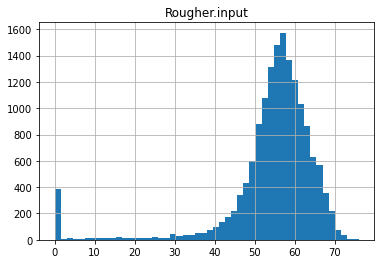

In [40]:
data_train_clean = data_train.loc[data_train['rougher.input'] != 0]
data_train_clean['rougher.input'].hist(bins=50)
plt.title('Rougher.input')
plt.show()

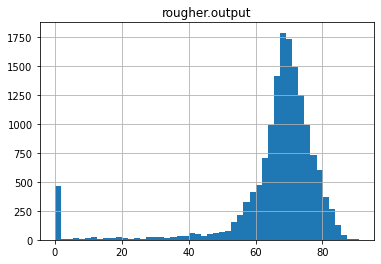

In [41]:
data_train_clean = data_train.loc[data_train['rougher.output'] != 0]
data_train_clean['rougher.output'].hist(bins=50)
plt.title('rougher.output')
plt.show()

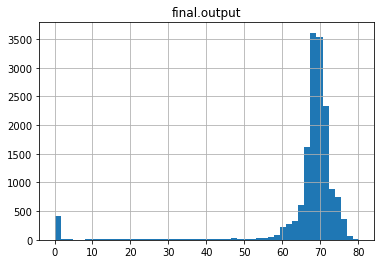

In [42]:
data_train_clean = data_train.loc[data_train['final.output'] != 0]
data_train_clean['final.output'].hist(bins=50)
plt.title('final.output')
plt.show()

<font color=green>

Teniendo y observando estos dos gráficos, podemos contestar la consulta hecha al principio:

    ¿Observamos algún valor anormal en la distribución total?
    
Respuesta: Si, tenemos varios valores anormales. En cada etapa tenemos valores tanto sobre como bajo los bigotes. Teniendo también un grupo cerca de valor 0.

    ¿Merece la pena eliminar esos valores de ambas muestras?
    
Respuesta: Sí, merece la pena eliminar esos valores, sobretodo los valores 0, ya que es un valor fuera de lo normal para este tipo de muestra en `rougher.output` y `final.output` y `rougher.input`.    
</font>

In [43]:
# Veamos el largo original del set de entrenamiento
# print('Largo original:', len(data_train))

# # Fijemos los limites de corte
# rougher_up = up_iqr_finder(data_train, 'rougher.output')
# rougher_down = down_iqr_finder(data_train, 'rougher.output')

# final_up = up_iqr_finder(data_train, 'final.output')
# final_down = down_iqr_finder(data_train, 'final.output')

# # Apliquemos la limpieza de datos atípicos
# data_train_clean = iqr_limit(data_train, rougher_up, rougher_down, 'rougher.output')
# data_train_clean = iqr_limit(data_train_clean, final_up, final_down, 'final.output')

# Veamos el largo luego de la limpieza
# print('Largo post limpieza:', len(data_train_clean))

<!-- <font color=green>

Haber eliminado los datos atípicos de nuestro DataFrame de entrenamiento, tenemos casi un 15% menos de datos.

No podremos hacer lo mismo con nuestro conjunto de prueba, ya que no tenemos las columnas estudiadas en esta sección.
</font> -->

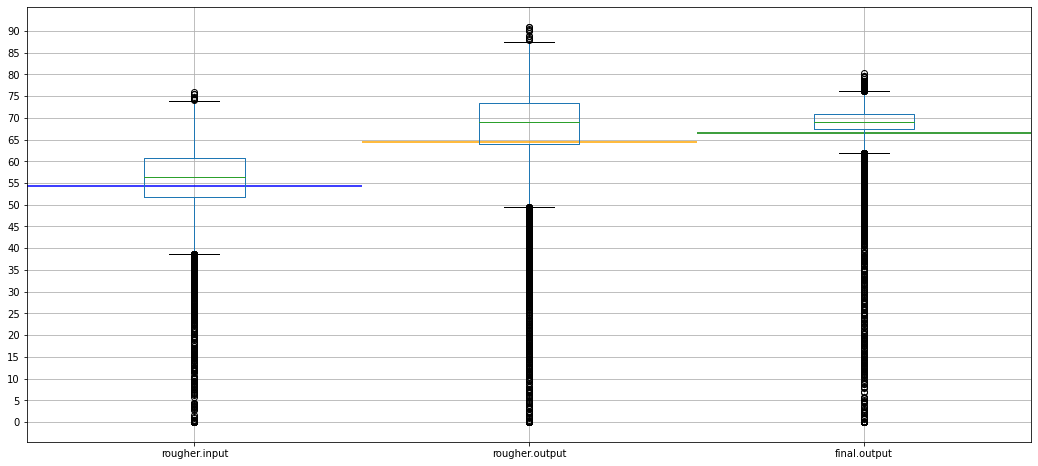

In [44]:
#Volvamos a ver la distribución de los datos limpios, con gráficos
data_train_clean.boxplot(['rougher.input', 'rougher.output','final.output'], figsize=(18,8))
plt.yticks(np.arange(0, 91, 5))
#Promedio de input del proceso rougher, en azul
plt.hlines(data_train_clean['rougher.input'].mean(),xmin=0.5,xmax=1.5,colors='blue')
#Promedio de output del proceso rougher, en naranja
plt.hlines(data_train_clean['rougher.output'].mean(),xmin=1.5,xmax=2.5,colors='orange')
#Promedio de output final del proceso, en verde
plt.hlines(data_train_clean['final.output'].mean(),xmin=2.5,xmax=3.5,colors='green')

plt.show()

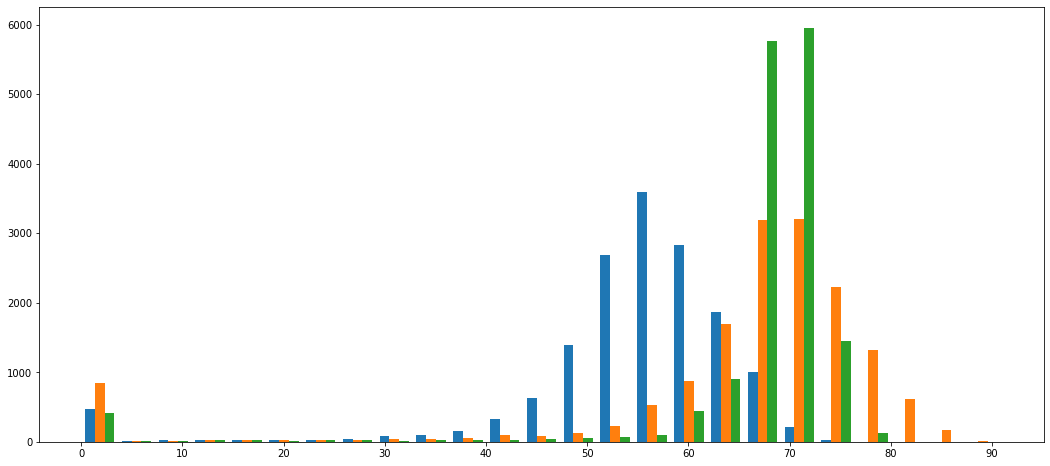

In [45]:
plt.figure(figsize=(18,8))
plt.hist([data_train_clean['rougher.input'], data_train_clean['rougher.output'], data_train_clean['final.output']], bins=25)
plt.xticks(np.arange(0, 91, 10))
plt.show()

<font color=green>

Ahora podemos observar que los datos se han vuelto más parejos y se encuentran ubicados alrededor de la mediana y media.
</font>

# Modelos predictivos

<font color=green>

Antes de que comenzemos con los modelos, crearemos la función sMAPE y nuestra semilla
</font>

In [46]:
def final_smape(target, prediction):
    # Función interna
    def smape(target_1,prediction_1):
        smaped = np.mean((np.abs(target_1 - prediction_1)/((np.abs(target_1)+np.abs(prediction_1))/2))) * 100
        return smaped
    
    # Calculo de smape final para Rougher[0] y Final[1]
    smape_rougher = smape(target.iloc[:,0], prediction[:,0]) 
    smape_final   = smape(target.iloc[:,1], prediction[:,1]) 
    final_smape   = (0.25 * smape_rougher) + (0.75 * smape_final)

    return final_smape

sMAPE_score = make_scorer(final_smape, greater_is_better = False) 

In [47]:
#Fijamos una semilla 
rs = RandomState(54321)

## Features y Targets

<font color=green>

</font>

In [48]:
#Antes de seguir creando los features y targets, verificamos la diferencia de columnas entre ambos DF, train y test

In [49]:
missing_columns_t_t = set(data_train.columns) - set(data_test.columns) #Obtenemos las columnas que faltan en el DataFrame de prueba

#Imprimimos las columnas que quedaron afuera
print('Columnas que quedaron fuera del DataFrame de prueba:')
print()
for columns in missing_columns_t_t:
    print(columns)

Columnas que quedaron fuera del DataFrame de prueba:

final.output.tail_pb
primary_cleaner.output.tail_au
rougher.output.tail_ag
secondary_cleaner.output.tail_au
final.output.concentrate_pb
rougher.output
primary_cleaner.output.tail_sol
rougher.calculation.floatbank10_sulfate_to_au_feed
final.output.concentrate_ag
secondary_cleaner.output.tail_ag
secondary_cleaner.output.tail_pb
primary_cleaner.output.concentrate_pb
primary_cleaner.output.tail_ag
primary_cleaner.output.concentrate_ag
rougher.output.tail_pb
final.output
primary_cleaner.output.concentrate_sol
rougher.output.concentrate_ag
primary_cleaner.output.concentrate_au
rougher.calculation.au_pb_ratio
rougher.output.concentrate_sol
final.output.concentrate_au
final.output.recovery
rougher.calculation.sulfate_to_au_concentrate
rougher.input
rougher.calculation.floatbank11_sulfate_to_au_feed
secondary_cleaner.output.tail_sol
final.output.concentrate_sol
primary_cleaner.output.tail_pb
final.output.tail_sol
rougher.output.tail_sol
roug

In [50]:
#Eliminamos todas las columnas, menos las dos necesarias
columns_to_delete = []
for missing in missing_columns_t_t:
    if missing not in ('rougher.output.recovery', 'final.output.recovery'):
        columns_to_delete.append(missing)
        
        
data_train_clean = data_train_clean.drop(columns = columns_to_delete ) #lo aplicamos a nuestro conjunto de train


In [51]:
#veamos como quedó
data_train_clean.shape

(15540, 55)

In [52]:
data_test.shape

(5856, 53)

In [53]:
#data_full.dtypes

In [54]:
#data_test.dtypes

In [55]:
#cambiamos el tipo de dato de la columna 'date' del conjunto test
data_test['date'] = pd.to_datetime(data_test['date'])

In [56]:
#cambiamos el tipo de dato de la columna 'date' del conjunto full
data_full['date'] = pd.to_datetime(data_full['date'])

<font color=green>

Este cambio de dtype de esa columna de ambos conjuntos, se tuvo que efectuar, para poder ejecutar el `.merge()`
</font>

In [57]:
#data_test.dtypes

In [58]:
#data_full.dtypes

In [59]:
#Juntamos las columnas necesarias para que nuestro conjunto de test cuente con ellos
data_test = data_test.merge(data_full[['date','rougher.output.recovery', 'final.output.recovery']], how = 'left', on = 'date')

In [60]:
#Veamos tamaño del conjunto test
data_test.shape

(5856, 55)

In [61]:
#Veamos tamaño conjunto train
data_train_clean.shape

(15540, 55)

In [62]:
#Vemos si son simétricos
set(data_train_clean.columns).symmetric_difference(set(data_train_clean.columns))

set()

In [63]:
#Verificamos si tenemos valores NaN
data_test.isna().sum().sum()

0

<font color=green>

Verificado todo y limpio y teniendo ambos conjuntos del mismo tamaño de columnas, podemos crear nuestros `features` y `targets`
</font>

In [64]:
#Creamos nuestros features y targets de ambos conjuntos
features_train = data_train_clean.drop(['date','rougher.output.recovery', 'final.output.recovery'], axis=1)
target_train = data_train_clean[['rougher.output.recovery', 'final.output.recovery']]
features_test = data_test.drop(['date','rougher.output.recovery', 'final.output.recovery'], axis=1)
target_test = data_test[['rougher.output.recovery', 'final.output.recovery']]

<font color=green>

Creados nuestros `features` y `targets` para los conjuntos correspondientes, podemos seguir con nuestros Modelos, con sus cross validation
</font>

## Modelos

In [65]:
reg = LinearRegression()
scores = cross_val_score(reg, features_train, target_train, cv=5, scoring=make_scorer(final_smape)) # < calcula las puntuaciones llamando a la función cross_value_score con cinco bloques >

final_score= sum(scores)/len(scores)

print('Puntuación media de la evaluación del modelo:', final_score)

Puntuación media de la evaluación del modelo: 14.320004178131308


In [66]:
tree = DecisionTreeRegressor()
scores = cross_val_score(tree, features_train, target_train, cv=5, scoring=make_scorer(final_smape)) # < calcula las puntuaciones llamando a la función cross_value_score con cinco bloques >

final_score= sum(scores)/len(scores)

print('Puntuación media de la evaluación del modelo:', final_score)

Puntuación media de la evaluación del modelo: 19.718144282308188


In [67]:
best_model = None
best_result = 1000
best_est = 0
best_depth = 0
for est in range(7,14,2):
    for depth in range (3,7):
        model = RandomForestRegressor(random_state=12345, n_estimators = est, max_depth=depth)    
        scores = cross_val_score(model, features_train, target_train, cv=4,scoring = make_scorer(final_smape))
        if scores.mean() < best_result:
            best_model = model
            best_result = scores.mean()
            best_est = est
            best_depth = depth
            
final_score = sum(scores)/len(scores)

print('Puntuación media de la evaluación del modelo:', final_score)        

Puntuación media de la evaluación del modelo: 12.410573150255436


In [68]:
# forest = RandomForestRegressor(n_estimators=80, max_depth=20, min_samples_leaf = 5,random_state=rs)
# scores = cross_val_score(forest, features_train, target_train, cv=5, scoring=make_scorer(final_smape)) # < calcula las puntuaciones llamando a la función cross_value_score con cinco bloques >

# final_score= sum(scores)/len(scores)

# print('Puntuación media de la evaluación del modelo:', final_score)

<font color=green>

Nuestro mejor modelo de los 3 es: `RandomForestRegressor` con una puntuación media de la evaluación de: 12.41
</font>

## Testeo de nuestro mejor modelo

In [69]:
#Bosque Aleatorio
best_model.fit(features_train, target_train)
pred = best_model.predict(features_test)
final_smape(target_test, pred)

12.598087807848572

In [70]:
# tree.fit(features_train, target_train)
# pred = tree.predict(features_test)
# final_smape(target_test, pred)

In [71]:
# reg.fit(features_train, target_train)
# pred = reg.predict(features_test)
# final_smape(target_test, pred)

In [72]:
#Dummy para prueba cordura
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(features_train, target_train)
pred = dummy_regr.predict(features_test)
final_smape(target_test, pred)

12.531788913477865

# Conclusión

<font color=green>
Después de analizar la información, comparar las cantidades de los metales en las distintas etapas de purificación, las distribuciones de las alimentaciones de las etapas y las concentraciones totales en las distintas etapas del proceso, con la ayuda de boxplot e histogramas, pudimos contar con datos confiables y dentro de rangos normales, eliminando valores atípicos.
        
    
    
Antes de comenzar a probar con 3 modelos predictivos, basándonos en la metrica sMAPE, tuvimos que hacer que nuestros conjuntos de entrenamiento y prueba sean coincidentes en columnas. Usamos nuestro conjunto completo, para llenar los datos faltantes (columnas) en el conjunto de prueba. Una vez hecho eso y hecho el merge, pudimos seguir con nuestros modelos, obteniendo mejores resultados con el modelo `RandomForestRegressor`, logrando obtener la mejor puntuación media de la evaluación, un 12.41.

Posteriormente, hicimos el testeo con el mejor modelo, obteniendo un valor final de sMape de 12.59
    
Además, se hizo una prueba de cordura obteniendo un valor final sMape de 13.18

Con este modelo se espera predecir los valores de oro que sean producidos por el proceso de purificación. Teniendo muestras de datos que se encuentren dentro del rango normal como los que seleccionamos.
</font>